# FGSM attack using MNIST dataset and LeNet Model

In [1]:
# Importing the required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
pretrained_model_path = 'lenet_mnist_model.pth'
epsilons = [0.00, 0.01, 0.03, 0.05, .10, .15, .20, 0.30, 0.50] #Degree of perturbation
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [3]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
# MNIST Test dataset
tfs = [transforms.ToTensor()]
transform = transforms.Compose(tfs)
ds_test = datasets.MNIST(root='data', download=True, train=False, transform=transform)
loader_test = torch.utils.data.DataLoader(ds_test, batch_size=1, shuffle=True)

In [5]:
# Initialize and load the network
model = Net().to(device)
model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [6]:
# Fast Gradient Sign Method (FGSM) Attack
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [7]:
# Testing our examples with the perturbations
def test(model, loader_test, epsilon):
    correct = 0
    adv_examples = []

    for data, target in loader_test:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True # For attack
        output = model(data)
        pred_init = output.max(1, keepdim=True)[1]

        if pred_init.item() != target.item():
            continue

        loss = F.nll_loss(output, target)
        loss.backward()

        data_grad = data.grad.data
        data = fgsm_attack(data, epsilon, data_grad)
        output = model(data)
        pred_final = output.max(1, keepdim=True)[1]

        if pred_final.item() != target.item():
            if len(adv_examples) < 5:
                adv_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append((pred_init.item(), pred_final.item(), adv_ex))
        else:
            correct = correct + 1
            if len(adv_examples) < 5 and epsilon == 0:
                adv_ex = data.squeeze().detach().cpu().numpy()
                adv_examples.append((pred_init.item(), pred_final.item(), adv_ex))
    acc = correct*1.0 / len(loader_test)
    print('Eps: {} \t Accuracy = {}/{}={:.3f}%'.format(epsilon, correct, len(loader_test), acc*100))
    return acc, adv_examples

In [8]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, loader_test, eps)
    accuracies.append(acc)
    examples.append(ex)

Eps: 0.0 	 Accuracy = 9810/10000=98.100%
Eps: 0.01 	 Accuracy = 9746/10000=97.460%
Eps: 0.03 	 Accuracy = 9612/10000=96.120%
Eps: 0.05 	 Accuracy = 9426/10000=94.260%
Eps: 0.1 	 Accuracy = 8510/10000=85.100%
Eps: 0.15 	 Accuracy = 6826/10000=68.260%
Eps: 0.2 	 Accuracy = 4301/10000=43.010%
Eps: 0.3 	 Accuracy = 869/10000=8.690%
Eps: 0.5 	 Accuracy = 63/10000=0.630%


In [9]:
import pandas as pd

d = {'Epsilon': epsilons, 'Accuracy': accuracies}
df = pd.DataFrame(d)
df

,Epsilon,Accuracy
0,0.00,0.9810
1,0.01,0.9746
2,0.03,0.9612
3,0.05,0.9426
4,0.10,0.8510
5,0.15,0.6826
6,0.20,0.4301
7,0.30,0.0869
8,0.50,0.0063


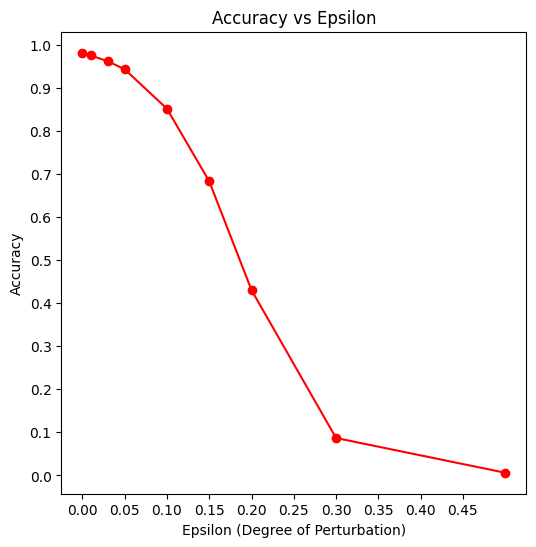

In [12]:
# Plotting the observed effect of perturbations (epsilons) on the accuracy of the model
plt.figure(figsize=(6,6))
plt.plot(epsilons, accuracies, 'o-r')

plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .50, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon (Degree of Perturbation)")
plt.ylabel("Accuracy");

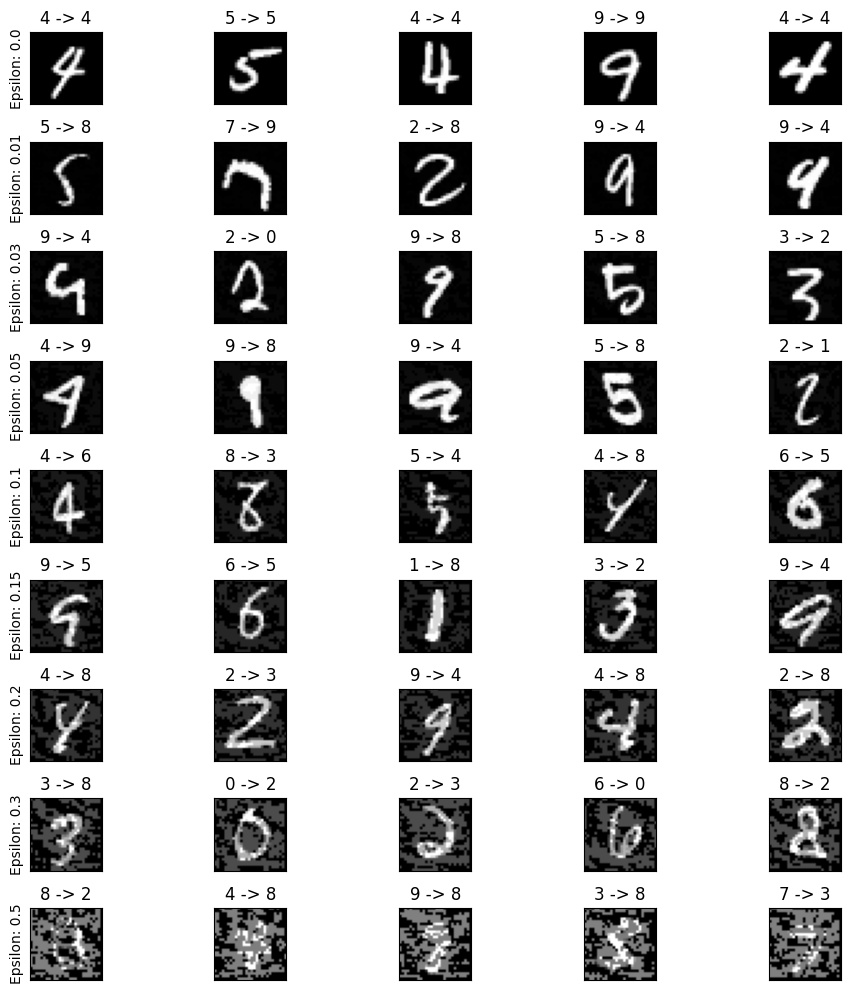

In [13]:
# Perturbed examples with their true class vs predicted class
plt.figure(figsize=(10,10))

cnt = 0
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt = cnt + 1
        plt.subplot(len(epsilons), len(examples[i]), cnt)
        orig, adv, ex = examples[i][j]

        plt.imshow(ex, cmap='gray')

        plt.xticks([], [])
        plt.yticks([], [])
        plt.title("{} -> {}".format(orig, adv))

        if j == 0:
            plt.ylabel("Epsilon: {}".format(epsilons[i]), fontsize=10)

plt.tight_layout()

We can clearly observe that, as we increase the epsilon value, the model starts misclassifying the predicted class. Small perturbations like epsilon = 0.01, 0.03, 0.05, 0.10 are ideal, as they cause sufficient misclassification, without having much difference to the human eye, as we can see in the chart above.